In [2]:
import pickle as pkl
from pprint import pprint
import tick
import numpy as np
from matplotlib import pyplot as plt

In [4]:
%matplotlib inline

In [6]:
#  load train data

with open('../../data/data_hawkesinhib/train.pkl', 'rb') as f:
    data = pkl.load(f,encoding='latin1')

In [7]:
# describe data
"""
    Event description format:
          'idx_event': event number in the sequence,
          'time_since_last_event': time elapsed from occurrence of previous event,
          'time_since_last_same_event': time elapsed from occurrence of previous event with same type,
          'time_since_start': time elapsed from sequence beginning,
          'type_event': event type,
"""

sequences = len(data['train'])  # count of event sequences
avg_samples_count = sum([len(item) for item in data['train']])//sequences #  average lengh of event sequence
event_types = set([item['type_event'] for sequence in data['train'] for item in sequence ])  #  event type markers
n_types = len(event_types) #  amount of event classes
print(f'Train sequences: {sequences}\nAvr count of events in sequence: {avg_samples_count}\n')
print(f'Amount of event types: {n_types},\nEvent type markers: {event_types}\n')
print('Data example:')
pprint(data['train'][0][0:3])


Train sequences: 8000
Avr count of events in sequence: 60

Amount of event types: 5,
Event type markers: {0, 1, 2, 3, 4}

Data example:
[{'idx_event': 1,
  'time_since_last_event': 0.5548047,
  'time_since_last_same_event': 0.5548047,
  'time_since_start': 0.5548047,
  'type_event': 0},
 {'idx_event': 2,
  'time_since_last_event': 1.1679047,
  'time_since_last_same_event': 1.7227094,
  'time_since_start': 1.7227094,
  'type_event': 1},
 {'idx_event': 3,
  'time_since_last_event': 0.11215174,
  'time_since_last_same_event': 1.2800565,
  'time_since_start': 1.8348612,
  'type_event': 0}]


In [8]:
# data transform
def data_preprocessing(data, n_types):
    data_processed = []
    for sequence in data:
        updated_sequence = [[] for _ in range(n_types)]
        for item in sequence:
            updated_sequence[item['type_event']].append(item['time_since_start'])
        updated_sequence = [np.array(item, dtype=np.double) for item in updated_sequence]
        data_processed.append(updated_sequence)
    return data_processed


In [9]:
from tick.plot import plot_hawkes_kernel_norms
def model_stats(model, test_data):
    plot_hawkes_kernel_norms(model,
                         node_names=list())
    print(f'log-likelihood: {model.score(test_data)}')
    pprint(model.adjacency)

In [10]:
with open('../../data/data_hawkesinhib/test.pkl', 'rb') as f:
    data_test = pkl.load(f,encoding='latin1')
    
test_events = data_preprocessing(data_test['test'], n_types)
processed_train = data_preprocessing(data['train'], n_types)





In [19]:
processed_train[0]

[array([0.55480468, 1.83486116, 2.80632067, 3.96395087, 4.33592749,
        5.03332901, 5.05364418, 5.50754023, 5.6828146 , 6.88051891,
        7.79980898, 8.60844898, 8.61282921]),
 array([1.72270942, 2.64998364, 4.44414759]),
 array([3.15885019, 9.18916988]),
 array([3.21331811, 5.2952075 , 8.32675266]),
 array([1.84739387, 2.26010966, 2.28192639, 3.67098045, 3.69758677,
        5.07235479, 5.36057854, 5.66092968, 6.3915267 , 7.5687561 ,
        8.37461758])]

In [55]:
from tick.hawkes import HawkesADM4
decay = .3
estimator_adm4 = HawkesADM4(decay,n_threads=6)
estimator_adm4.fit(processed_train[1])
model_stats(estimator_adm4, processed_train[1])

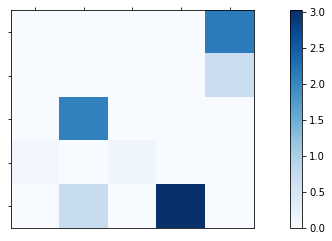

log-likelihood: 0.2786031733591441
array([[3.55271368e-14, 1.33226763e-14, 4.44089210e-15, 7.09756184e-05,
        2.15448229e+00],
       [8.88178420e-15, 2.22044605e-15, 0.00000000e+00, 5.55111512e-16,
        6.80025809e-01],
       [4.44089210e-15, 2.08801496e+00, 2.22044605e-15, 5.55111512e-16,
        1.55431223e-14],
       [9.74565612e-02, 2.22044605e-15, 1.53201565e-01, 0.00000000e+00,
        0.00000000e+00],
       [4.44089210e-15, 7.28613416e-01, 0.00000000e+00, 3.02065863e+00,
        0.00000000e+00]])


In [40]:
from tick.hawkes import HawkesExpKern, HawkesSumExpKern, HawkesSumGaussians

decays_exp_kern = np.random.random([n_types, n_types])
decays_sum_exp_kern =  [5]

In [41]:
estimator_exp_kern = HawkesExpKern(decays_exp_kern)
estimator_exp_kern.fit(processed_train)
model_stats(estimator_exp_kern, test_events)

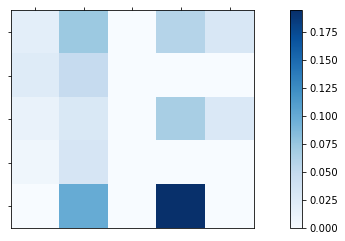

log-likelihood: 0.8412918129515913
array([[1.94103337e-02, 7.41697768e-02, 0.00000000e+00, 5.89654472e-02,
        3.04101282e-02],
       [2.45719425e-02, 4.88596370e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.41599231e-02, 2.93639501e-02, 5.13916227e-04, 6.72733435e-02,
        2.87241399e-02],
       [7.78607267e-03, 3.26159123e-02, 1.58144681e-04, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 9.93557051e-02, 0.00000000e+00, 1.94060781e-01,
        0.00000000e+00]])


In [42]:
model_stats(estimator_exp_kern, test_events)

In [44]:
estimator_sum_exp_kern = HawkesSumExpKern([11.97332586, 28.21542404, 11.400408  ])
estimator_sum_exp_kern.fit(processed_train)

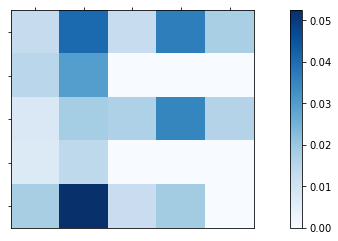

log-likelihood: 0.8517828234802646
array([[[0.        , 0.        , 0.01303192],
        [0.        , 0.01876643, 0.0220005 ],
        [0.        , 0.00441967, 0.00814505],
        [0.00371563, 0.        , 0.03314966],
        [0.00259893, 0.00357515, 0.01184948]],

       [[0.00550578, 0.00419502, 0.00563906],
        [0.00033015, 0.01159387, 0.01799949],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.00206546, 0.00336946, 0.00217253],
        [0.00097136, 0.00340059, 0.01413329],
        [0.        , 0.00832002, 0.00884907],
        [0.0076824 , 0.        , 0.02770168],
        [0.00771823, 0.        , 0.00835858]],

       [[0.00238317, 0.00163164, 0.00302604],
        [0.00083924, 0.0014652 , 0.01220481],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.00435069, 0.00359489, 0.01

In [45]:
model_stats(estimator_sum_exp_kern, test_events)

In [48]:
from scipy.optimize import basinhopping

def optimise_decays_sum_exp_kern(decays):
    est = HawkesSumExpKern(decays)
    est.fit(processed_train)
    return -est.score(test_events)

ret = basinhopping(optimise_decays_sum_exp_kern, [11, 28, 11, 3, 2], niter=1, minimizer_kwargs = {"method": "L-BFGS-B"})

In [50]:
ret

                        fun: -0.8517661668683926
 lowest_optimization_result:       fun: -0.8517661668683926
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.86197708e-06,  1.45439204e-06, -3.61932676e-06, -6.99440448e-07,
       -1.37667644e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 54
      nit: 3
     njev: 9
   status: 0
  success: True
        x: array([11.21692811, 21.33531173, 12.88674563, 28.56137485, 15.62234539])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 150
                        nit: 1
                       njev: 25
                          x: array([11.21692811, 21.33531173, 12.88674563, 28.56137485, 15.62234539])

In [29]:
hawkes.timestamps[0][1:] - hawkes.timestamps[0][:-1]

array([8.99374205e-01, 1.33517339e+00, 1.27971325e-01, 2.24329406e-01,
       5.05215378e-02, 2.19769298e+00, 2.15245175e-02, 3.49651779e-01,
       4.35951832e-02, 6.75598628e-02, 1.78188298e-02, 2.35137230e-02,
       1.00217624e-01, 3.89649846e-01, 4.47773802e-02, 6.59793578e-01,
       1.29628064e+00, 3.76289686e-01, 1.02458938e+00, 5.53725501e-02,
       5.39328587e-01, 4.64592766e+00, 4.66886941e-01, 2.63664283e-01,
       1.86438382e+00, 2.08867791e+00, 1.58321577e-01, 1.06631930e+00,
       1.05520110e-01, 7.79899638e-02, 7.13265269e-02, 4.83663755e-01,
       5.36155332e-01, 1.07729128e+00, 2.50486908e-01, 1.37256151e+00,
       2.85866638e+00, 3.54055504e-02, 7.75204475e-01, 1.33560434e+00,
       1.02416853e-01, 5.90088664e-02, 1.09591613e-01, 7.36525813e-01,
       8.66619638e-01, 1.67161897e-01, 1.81693525e-01, 1.57537944e-02,
       2.14773854e-01, 2.12027087e-01, 1.17885330e-01, 6.31115656e-04,
       7.13736878e-02, 4.46259088e-01, 1.69871349e+00, 3.54910136e+00,
      

In [41]:
from collections import OrderedDict

In [45]:
import pandas as pd

In [72]:
from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process

n_nodes = 2  # dimension of the Hawkes process
adjacency = 0.2 * np.ones((n_nodes, n_nodes))
adjacency[0, 1] = 0
adjacency[1, 0] = 0
# adjacency[1, 2] = 0
# adjacency[2, 1] = 0

decays = 3 * np.ones((n_nodes, n_nodes))
baseline = 0.5 * np.ones(n_nodes)


dataset = []
for i in range(1200):
    hawkes = SimuHawkesExpKernels(adjacency=adjacency,
                                  decays=decays,
                                  baseline=baseline,
                                  verbose=False)

    run_time = 50
    hawkes.end_time = run_time
    dt = 0.01
    hawkes.track_intensity(dt)
    hawkes.simulate()

    events_df = pd.DataFrame(columns = ['type_event', 'time_since_start'])
    for i in hawkes.timestamps[0]:
        events_df = events_df.append(pd.DataFrame({'type_event':0, 
                                                   'time_since_start':i}, index = [0]))
        
    for i in hawkes.timestamps[1]:
        events_df = events_df.append(pd.DataFrame({'type_event':1, 
                                                   'time_since_start':i}, index = [0]))  
        
    events_df = events_df.sort_values('time_since_start').reset_index(drop = True)
    events_df['time_since_last_event'] = events_df.time_since_start.diff(1).fillna(0)
    events_df['idx_event'] = events_df.index + 1
    dict_to_save = events_df.to_dict(orient = 'records')
    dataset.append(dict_to_save)

# fig, ax = plt.subplots(n_nodes, 1, figsize=(16, 8), sharex=True, sharey=True)
# plot_point_process(hawkes, n_points=50000, t_min=10, max_jumps=30, ax=ax)
# fig.tight_layout()

In [81]:
len(dataset[0])

128

In [74]:
len(dataset)

1200

In [75]:
train = dataset[:1100]
dev = dataset[1100:1150]
test = dataset[1150:]

In [76]:
path = '../../data/synthetic_data_2events/'

In [77]:
import pickle

In [80]:
with open(path + 'train.pkl', 'wb') as f:
    pickle.dump({'train': train}, f)

with open(path + 'dev.pkl', 'wb') as f:
    pickle.dump({'dev': dev}, f)
    
with open(path + 'test.pkl', 'wb') as f:
    pickle.dump({'test': test}, f)

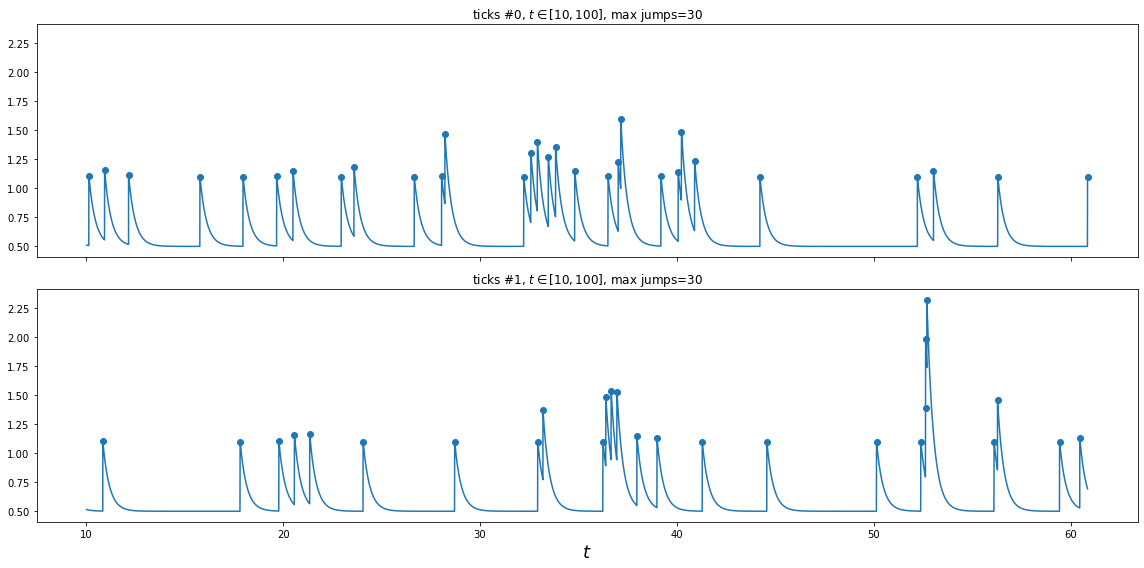

In [86]:
fig, ax = plt.subplots(n_nodes, 1, figsize=(16, 8), sharex=True, sharey=True)
plot_point_process(hawkes, n_points=50000, t_min=10, max_jumps=30, ax=ax)
fig.tight_layout()

In [87]:
hawkes.tracked_intensity

[array([0.5       , 0.5       , 0.5       , ..., 0.56246633, 0.56062017,
        0.55882857]), array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])]

[{'type_event': 0,
  'time_since_start': 0.5102921148350066,
  'time_since_last_event': 0.0},
 {'type_event': 1,
  'time_since_start': 0.6846441187450736,
  'time_since_last_event': 0.174352003910067},
 {'type_event': 0,
  'time_since_start': 1.0871380211406425,
  'time_since_last_event': 0.4024939023955689},
 {'type_event': 0,
  'time_since_start': 1.1382551922505593,
  'time_since_last_event': 0.05111717110991676},
 {'type_event': 1,
  'time_since_start': 1.5077806453190572,
  'time_since_last_event': 0.36952545306849793},
 {'type_event': 1,
  'time_since_start': 2.2094630897707184,
  'time_since_last_event': 0.7016824444516612},
 {'type_event': 0,
  'time_since_start': 2.788285466009115,
  'time_since_last_event': 0.5788223762383966},
 {'type_event': 0,
  'time_since_start': 3.082465927283688,
  'time_since_last_event': 0.2941804612745731},
 {'type_event': 0,
  'time_since_start': 3.3085319537347857,
  'time_since_last_event': 0.22606602645109763},
 {'type_event': 1,
  'time_since_s

In [40]:
events_dict

[{'type_event': 0, 'time_since_start': 0.5102921148350066},
 {'type_event': 0, 'time_since_start': 1.0871380211406425},
 {'type_event': 0, 'time_since_start': 1.1382551922505593},
 {'type_event': 0, 'time_since_start': 2.788285466009115},
 {'type_event': 0, 'time_since_start': 3.082465927283688},
 {'type_event': 0, 'time_since_start': 3.3085319537347857},
 {'type_event': 0, 'time_since_start': 3.658360566003923},
 {'type_event': 0, 'time_since_start': 3.9854439229784764},
 {'type_event': 0, 'time_since_start': 4.519227251338172},
 {'type_event': 0, 'time_since_start': 7.157329739061552},
 {'type_event': 0, 'time_since_start': 9.76996506641645},
 {'type_event': 0, 'time_since_start': 10.765324385465608},
 {'type_event': 0, 'time_since_start': 11.675141401329705},
 {'type_event': 0, 'time_since_start': 15.23574194135264},
 {'type_event': 0, 'time_since_start': 15.756463680152576},
 {'type_event': 0, 'time_since_start': 20.77822080555206},
 {'type_event': 0, 'time_since_start': 20.8060886

[{'type_event': 0, 'time_since_start': 0.05876903262250776},
 {'type_event': 0, 'time_since_start': 0.9581432375431},
 {'type_event': 0, 'time_since_start': 2.2933166270542062},
 {'type_event': 0, 'time_since_start': 2.4212879515880674},
 {'type_event': 0, 'time_since_start': 2.6456173572506065},
 {'type_event': 0, 'time_since_start': 2.696138895037597},
 {'type_event': 0, 'time_since_start': 4.893831879717181},
 {'type_event': 0, 'time_since_start': 4.915356397184834},
 {'type_event': 0, 'time_since_start': 5.265008176575569},
 {'type_event': 0, 'time_since_start': 5.308603359814368},
 {'type_event': 0, 'time_since_start': 5.37616322265164},
 {'type_event': 0, 'time_since_start': 5.393982052405093},
 {'type_event': 0, 'time_since_start': 5.417495775416162},
 {'type_event': 0, 'time_since_start': 5.517713399132921},
 {'type_event': 0, 'time_since_start': 5.9073632449862545},
 {'type_event': 0, 'time_since_start': 5.952140625159841},
 {'type_event': 0, 'time_since_start': 6.611934203128

[array([ 0.51029211,  1.08713802,  1.13825519,  2.78828547,  3.08246593,
         3.30853195,  3.65836057,  3.98544392,  4.51922725,  7.15732974,
         9.76996507, 10.76532439, 11.6751414 , 15.23574194, 15.75646368,
        20.77822081, 20.80608867, 21.05887577, 21.22894456, 28.53531022,
        28.80665367, 33.78632537, 34.18175066, 34.26602709, 34.67314923,
        34.75257463, 36.37823184, 38.84307313, 38.93055523, 40.49480541,
        42.18611311, 42.2248858 , 42.6834143 , 45.11283997, 45.66810064,
        45.77203212, 47.32039643, 50.06594178, 52.32173864, 52.66165895,
        53.04182305, 55.61313016, 55.80440089, 55.81967842, 59.30158286,
        60.09845591, 60.3087108 , 60.71004522, 60.78437019, 60.84096062,
        60.87228564, 60.94247433, 61.31115119, 61.33937876, 61.92139544,
        64.91899202, 65.42456248, 65.54453527, 66.09008311, 66.23373718,
        66.36233848, 66.99382301, 68.00861647, 69.99250112, 72.65732983,
        72.95412835, 74.23617614, 75.40173546, 75.5

In [11]:
hawkes.

(10164,)

In [218]:
hawkes.timestamps

[array([ 1.60587112,  1.71987793,  1.79944136,  1.90689703,  1.98117648,
         2.07339472,  2.44615675,  3.49935109,  4.93684915,  5.18120843,
         7.44047277,  7.45384409,  7.56132439,  7.62317696, 10.22056671,
        10.32461736, 10.35714381, 10.42717845, 11.75145983, 13.51922485,
        13.54335315, 13.95261807, 14.38581289, 14.54160569, 15.17465103,
        15.23507361, 15.33654771, 15.35290586, 15.58206707, 15.62020612,
        15.93080842, 16.04070115, 16.17246717, 16.44326127, 16.51500078,
        16.59534716, 16.99435081, 17.036775  , 17.04032805, 17.78752037,
        18.11141526, 18.24289401, 18.26459087, 18.28071641, 18.28945966,
        18.41342243, 18.41950108, 18.55084959, 19.06236625, 19.19730184,
        19.22900498, 19.36592624, 19.39555881, 19.42261663, 19.55462345,
        19.73737989, 20.20839717, 21.08915043, 22.02579636, 22.08147927,
        22.37776569, 22.46570223, 23.5637442 , 26.53240554, 26.85393362,
        27.06497797, 27.61867865, 28.4103586 , 28.7

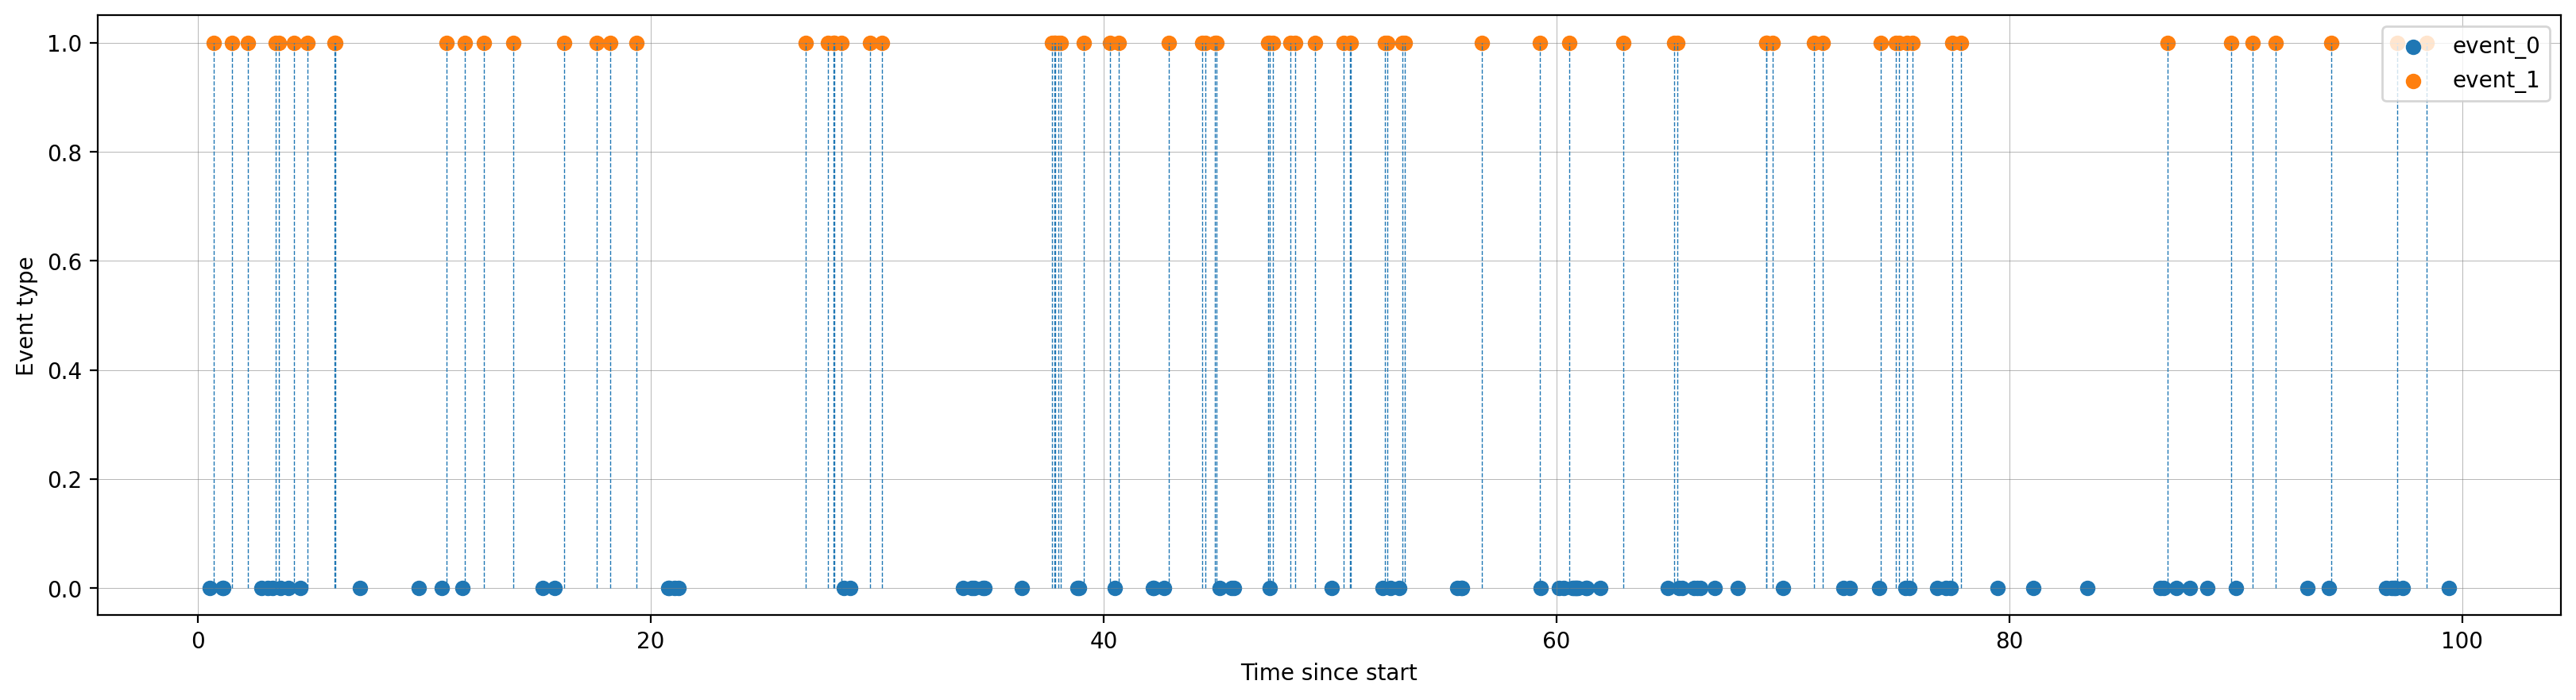

In [14]:
plt.figure(figsize = (20, 5), dpi = 200)
plt.grid(color='gray', linestyle='-', linewidth=0.2)
for i in range(2):
    times = hawkes.timestamps[i]
    events = [i]*len(times)
    plt.scatter(times,
                events,
                label = f'event_{i}')

    plt.vlines(times, [0]*len(events), events, linestyle='--', linewidth=0.5)

plt.legend(loc = 'upper right')
plt.xlabel('Time since start')
plt.ylabel('Event type')
plt.show()

In [17]:
A = np.random.random((7, 7))
A[A<=0.5] = 0.2
A[A>0.5] = 0

In [18]:
A

array([[0. , 0.2, 0.2, 0. , 0. , 0.2, 0.2],
       [0.2, 0.2, 0. , 0.2, 0. , 0. , 0. ],
       [0.2, 0. , 0.2, 0.2, 0.2, 0. , 0. ],
       [0.2, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.2, 0. , 0. , 0.2, 0.2, 0.2],
       [0.2, 0.2, 0. , 0.2, 0.2, 0. , 0.2],
       [0. , 0.2, 0. , 0. , 0.2, 0. , 0. ]])

In [19]:
import seaborn as sns

<AxesSubplot:>

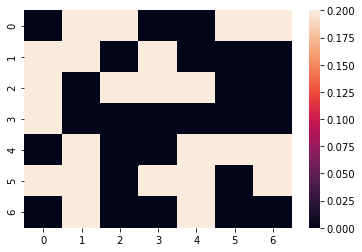

In [20]:
sns.heatmap(A)

In [21]:
ts = []
for i in range(100):
    n_nodes = len(A)
    decays = 3 * np.ones((n_nodes, n_nodes))
    baseline = 0.5 * np.ones(n_nodes)
    hawkes = SimuHawkesExpKernels(adjacency=A, decays=decays,
                                  baseline=baseline, verbose=False)

    run_time = 100
    hawkes.end_time = run_time
    dt = 0.01
    hawkes.track_intensity(dt)
    hawkes.simulate()
    ts.append(hawkes.timestamps)


In [24]:
ts[0]

[array([ 0.39327721,  0.42024959,  0.70829937,  1.02853541,  2.99289119,
         2.99852074,  3.25888698,  3.29672991,  3.38598228,  3.6447237 ,
         4.07698341,  4.16510926,  4.27985896,  4.5099589 ,  5.04251966,
         5.05942152,  5.23612732,  5.2748053 ,  5.84572745,  5.99521042,
         6.01125199,  6.1523711 ,  6.32431201,  6.88830511,  7.13777304,
         7.77330921,  7.94363212,  8.0056162 ,  8.21513366,  8.24508023,
         8.42398923,  8.81214726,  8.96640482,  9.03043738,  9.29983848,
         9.50873752,  9.98622459, 10.12518156, 10.41491701, 10.45844729,
        11.45532328, 11.64602173, 11.82923169, 12.3871284 , 12.59413934,
        13.28941392, 13.335435  , 13.46658618, 13.69026066, 14.2601009 ,
        14.58066272, 15.81433417, 15.84190241, 16.75755603, 16.90247638,
        16.91957877, 16.97903689, 17.39859879, 17.6311242 , 18.17748174,
        18.25439232, 18.67591996, 18.77348162, 18.92825468, 19.18772272,
        19.19090383, 19.3628051 , 19.43888767, 19.8

In [23]:
decays_exp_kern = np.random.random([len(A), len(A)])
decays_sum_exp_kern = [3]

estimator_exp_kern = HawkesExpKern(decays_exp_kern)
estimator_exp_kern.fit(ts)
model_stats(estimator_exp_kern, ts)

NameError: name 'HawkesExpKern' is not defined

In [198]:
np.set_printoptions(suppress=True)

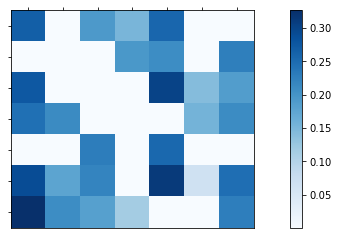

log-likelihood: 0.3597225390703459
array([[0.26744465, 0.00000004, 0.19380704, 0.1522623 , 0.25871442,
        0.00000005, 0.00000069],
       [0.00049535, 0.0000001 , 0.00001757, 0.19617402, 0.20987906,
        0.00000001, 0.22787416],
       [0.27660688, 0.00000128, 0.00001382, 0.00000001, 0.30255635,
        0.1427405 , 0.18872734],
       [0.24574501, 0.21294216, 0.00016534, 0.00000468, 0.00074613,
        0.1563403 , 0.21173094],
       [0.        , 0.        , 0.23021212, 0.        , 0.25588844,
        0.        , 0.        ],
       [0.29209865, 0.1775157 , 0.22116624, 0.00000019, 0.31309732,
        0.06699665, 0.24824246],
       [0.32667923, 0.20955802, 0.1837615 , 0.1169177 , 0.00000003,
        0.00000002, 0.2294854 ]])


In [199]:
decay = .3
estimator_adm4 = HawkesADM4(decay,n_threads=6)
estimator_adm4.fit(ts)
model_stats(estimator_adm4, ts)

<AxesSubplot:>

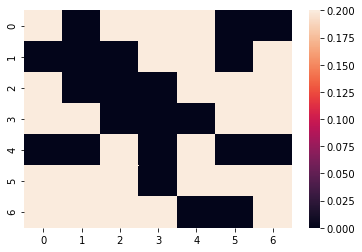

In [200]:
sns.heatmap(A)

In [204]:
A_new = np.array([[0.26744465, 0.00000004, 0.19380704, 0.1522623 , 0.25871442,
        0.00000005, 0.00000069],
       [0.00049535, 0.0000001 , 0.00001757, 0.19617402, 0.20987906,
        0.00000001, 0.22787416],
       [0.27660688, 0.00000128, 0.00001382, 0.00000001, 0.30255635,
        0.1427405 , 0.18872734],
       [0.24574501, 0.21294216, 0.00016534, 0.00000468, 0.00074613,
        0.1563403 , 0.21173094],
       [0.        , 0.        , 0.23021212, 0.        , 0.25588844,
        0.        , 0.        ],
       [0.29209865, 0.1775157 , 0.22116624, 0.00000019, 0.31309732,
        0.06699665, 0.24824246],
       [0.32667923, 0.20955802, 0.1837615 , 0.1169177 , 0.00000003,
        0.00000002, 0.2294854 ]])
scaler = MinMaxScaler()
A_new = scaler.fit_transform(A_new)

In [205]:
A_new[A_new>0.5] = 1
A_new[A_new<0.5] = 0

<AxesSubplot:>

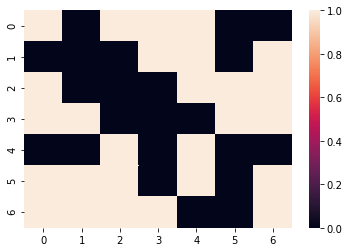

In [206]:
sns.heatmap(A_new)

In [207]:
learner = HawkesSumGaussians(5, max_iter=100)
learner.fit(ts)



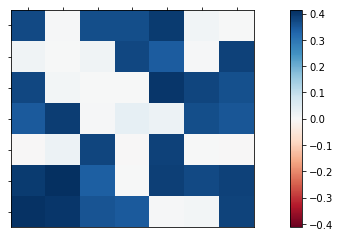

AttributeError: 'HawkesSumGaussians' object has no attribute 'score'

In [208]:
model_stats(learner, ts)

In [210]:
learner.get_kernel_norms()

array([[ 0.37352678,  0.00341466,  0.36599284,  0.3679019 ,  0.39691366,
         0.01371682,  0.0026932 ],
       [ 0.01645172,  0.00197893,  0.01638357,  0.37810095,  0.34536125,
         0.00516997,  0.38470714],
       [ 0.37584786,  0.01146852,  0.00232548,  0.00066879,  0.40141234,
         0.38044957,  0.36263596],
       [ 0.34858168,  0.39173881,  0.0052162 ,  0.03574606,  0.02571501,
         0.36552775,  0.35453745],
       [-0.00169139,  0.02351452,  0.38099988, -0.00107822,  0.38473804,
         0.00005307, -0.00199177],
       [ 0.39499657,  0.41371179,  0.34037356,  0.00158469,  0.38821734,
         0.37252927,  0.38586988],
       [ 0.40773718,  0.40314678,  0.3569445 ,  0.34661282,  0.00489719,
         0.00969737,  0.38416673]])

In [211]:
from sklearn.preprocessing import MinMaxScaler

In [212]:
scaler = MinMaxScaler()
A_new = scaler.fit_transform(learner.get_kernel_norms())

<AxesSubplot:>

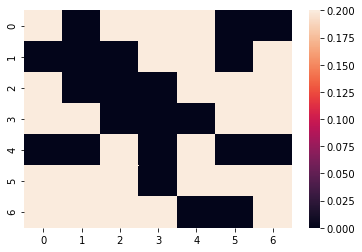

In [213]:
sns.heatmap(A)

<AxesSubplot:>

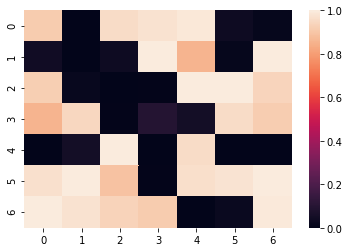

In [214]:
sns.heatmap(A_new)

In [ ]:
tick.plot.plot_hawkes_kernels